# 4. Feature selection

Our data set most probably includes thousands and thousands of unique words. Making each of them separate features would be completely unreasonable - and unnecessary. Instead, I will choose a subset of most impactful words that I would then use in feature engineering.

## Table of Contents

1. [Load pre-processed data](#Load-pre-processed-data)
1. [Identify most frequent words](#Identify-most-frequent-words)
1. [Build frequency matrix](#Build-frequency-matrix)
1. [Define inputs for feature selection](#Define-inputs-for-feature-selection)
1. [Use Chi-squared to select best features](#Use-Chi-squared-to-select-best-features)
1. [Plot the results](#Plot-the-results)
1. [Save best features](#Save-best-features)

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix, save_npz, load_npz
import matplotlib.pyplot as plt
%matplotlib inline

## Load pre-processed data

In [2]:
data = np.load('files/data.npz', allow_pickle=True)
data.files

['company', 'train', 'labels', 'words']

## Identify most frequent words

First, I would like to filter out a long tail of highly infrequent words. Let's look at the total number of words available in the data set:

In [3]:
# narrow down to training set only
data_train = data['words'][data['train']]

In [4]:
words, counts = np.unique(data_train, return_counts=True)

In [5]:
words.shape

(105510,)

As we can see, this gives us a total of 100K+ words. Even at the feature selection phase, working with an array so large might be problematic. However, applying even a relatively "safe" filter of 100+ minimum word count can allow us to dramatically reduce the total number of features to explore:

In [6]:
# filter down to only words with a minimum count of 100
top_features = words[counts > 100]
top_features.shape

(6374,)

## Build frequency matrix

With the more frequent words in mind, we now need to construct an array of words and their frequencies, grouped by labels (i.e., report section)

In [7]:
# narrow down to training set only
labels_train = data['labels'][data['train']]
labels_unique = np.unique(labels_train)

In [8]:
# calculate word frequencies for each label
frequencies = [np.unique(data_train[labels_train==i], return_counts=True) for i in labels_unique]

In [9]:
# add labels to each frequency group
frequencies = [np.array([np.repeat(labels_unique[i], words.shape[0]), words, counts]) \
               for i, (words, counts) in enumerate(frequencies)]

In [10]:
# stack frequency groups to create a single matrix with labels, words, and word counts
frequencies = np.hstack(frequencies).T

## Define inputs for feature selection

Now that we have a frequency matrix we can define inputs that would go into our feature selection model:

In [11]:
# define a top feature index
is_top_feature = np.isin(frequencies[:, 1], top_features)

In [12]:
# one-hot encode words in the frequency matrix
enc = OneHotEncoder()
one_hot = enc.fit_transform(frequencies[is_top_feature, 1].reshape(-1, 1))

In [13]:
# multiply one-hot encoded words by their word counts to create the inputs array
counts = frequencies[is_top_feature, 2].astype(np.int64).reshape(-1, 1)
X = one_hot.multiply(counts)
X.shape

(14034, 6374)

In [14]:
# filter down to labels for top features only to create the target array
y = frequencies[is_top_feature, 0].astype(np.int64)
y.shape

(14034,)

## Use Chi-squared to select best features

Now I will use `SelectKBest` model from `sklearn.feature_selection` module to pull 100 best features based on their Chi-squared scores. Chi-squared would estimate whether relative frequency of each word is significantly different across the three sections of the report (used as labels in our Chi-squared test):

In [15]:
ch2 = SelectKBest(chi2, 100)

In [16]:
# fit the model
ch2.fit(X, y)

SelectKBest(k=100, score_func=<function chi2 at 0x1a1ab4b268>)

In [17]:
# pull the indices of top features
feat_indices = ch2.get_support()

In [18]:
# pull the names of top features
best_features = enc.categories_[0][feat_indices]
best_features

array(['', '<number>', 'a', 'ability', 'able', 'act', 'addition',
       'additional', 'adverse', 'adversely', 'affect', 'also', 'an',
       'and', 'any', 'are', 'as', 'assets', 'at', 'be', 'believe',
       'business', 'by', 'can', 'capital', 'clinical', 'companies',
       'company', 'compared', 'condition', 'continue', 'could',
       'customers', 'data', 'december', 'deferred', 'development', 'do',
       'factors', 'fair', 'financial', 'for', 'forward-looking', 'from',
       'future', 'growth', 'have', 'if', 'in', 'including', 'increase',
       'increased', 'industry', 'information', 'is', 'item', 'laws',
       'market', 'marketing', 'may', 'million', 'more', 'new', 'not',
       'note', 'obtain', 'of', 'on', 'operations', 'or', 'other', 'our',
       'product', 'products', 'regulations', 'regulatory', 'required',
       'requirements', 'result', 'results', 'risks', 'sales',
       'securities', 'services', 'stock', 'subject', 'such', 'tax',
       'that', 'the', 'their', 'the

## Plot the results

To illustrate that remaining features represent a "long tail" with significantly lower Chi-squared scores and higher p-values, let's create a chart plotting feature rank vs. Chi-squared score (log scale, on the left) and p-value (log scale, on the right):

In [19]:
ch2_df = pd.DataFrame({'feature': enc.categories_[0], 'score': ch2.scores_, 'pval': ch2.pvalues_})
ch2_df.sort_values(by='score', ascending=False, inplace=True)

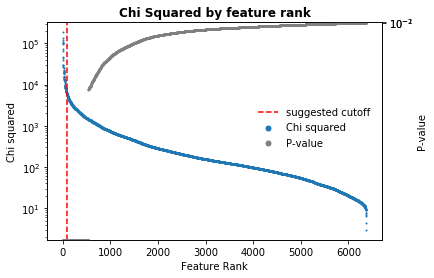

In [20]:
fig, ax = plt.subplots()
x = range(1, ch2_df.shape[0]+1)
ax.scatter(x=x, y=ch2_df.score, s=1, label='Chi squared')
ax.set_ylabel('Chi squared')
ax.set_yscale('log')
ax.set_xlabel('Feature Rank')

ax2 = ax.twinx()
ax2.scatter(x=x, y = ch2_df.pval, color='grey', s=1, label='P-value')
ax2.set_ylim((0, 0.1))
ax2.set_yscale('log')
ax2.set_ylabel('P-value')

ax.axvline(100, color='red', ls='--', label='suggested cutoff')
ax.set_title('Chi Squared by feature rank', fontweight='bold')

ax.legend(bbox_to_anchor=(0.992, 0.65), markerscale=5, frameon=False)
ax2.legend(bbox_to_anchor=(0.85, 0.51), markerscale=5, frameon=False);

As we can see, features below our suggested cutoff of top 100 features have significantly lower Chi-squared score (mostly in 1,000-s range and below vs. top 100 features having scores around 10 - 100K) and - for majority of them - a really high p-value.

## Save best features

In [21]:
# Save best features into a file for future re-use
np.savez('files/best_features.npz', best_features=best_features)